## 1. Importing Necessary Libraries ##

In [ ]:
import re

import pandas as pd
import numpy as np

from matplotlib import pyplot as plt
%matplotlib inline

from nltk import SnowballStemmer
from nltk.corpus import stopwords

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, LabelEncoder

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, LSTM, Conv1D, MaxPooling1D, Dropout, Activation , Embedding, GlobalMaxPooling1D, Bidirectional

from tensorflow.keras.callbacks import EarlyStopping

In [ ]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 5540882297201871021
, name: "/device:XLA_CPU:0"
device_type: "XLA_CPU"
memory_limit: 17179869184
locality {
}
incarnation: 18000852768669485186
physical_device_desc: "device: XLA_CPU device"
, name: "/device:XLA_GPU:0"
device_type: "XLA_GPU"
memory_limit: 17179869184
locality {
}
incarnation: 3151853255040143810
physical_device_desc: "device: XLA_GPU device"
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 14640891840
locality {
  bus_id: 1
  links {
  }
}
incarnation: 9944809141333368813
physical_device_desc: "device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5"
]


## 2. Reading and Visualization of the dataset

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
main_directory = '/content/drive/My Drive/My Works/Bangla YouTube/Emotion.csv'

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [ ]:

import nltk
nltk.download('stopwords')
nltk_stop_words = list(stopwords.words('english'))

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [ ]:
dataset = pd.read_csv(main_directory,encoding = 'utf-8',sep=';')
dataset.head()

,id,text,emotion,lan,domain
0,2275,Hands down. You are good. I mean smart good.,joy,EN,funny_video
1,2283,Your are very good. keep it up,none,EN,funny_video
2,2292,Man!! I will never get used to these videos of...,surprise,EN,funny_video
3,2293,ডিসলাইক দেয়া 32,none,BN,funny_video
4,2298,ব্যাপক বিনোদন।,joy,BN,funny_video


In [ ]:
dataset = dataset.sample(frac=1).reset_index(drop=True)
dataset.head()

,id,text,emotion,lan,domain
0,23335,"kausik das, I agree with you. But government w...",none,EN,news_video
1,22162,Alam re anen na plzz\n,none,RN,funny_video
2,4219,আমিও তো অনেক Innocent\n,none,BN,drama_video
3,27698,জয় বাংলা!!\n,joy,BN,news_video
4,25359,Vai Ami apner maer voda chat te chai\n,none,RN,talkshow_video


In [ ]:
# Get indexes where name column has value john
indexNames = dataset[(dataset['lan'] == 'BN') | (dataset['lan'] == 'RN')].index

# Delete these row indexes from dataFrame
dataset = dataset.drop(indexNames)

In [ ]:
dataset.head()

,id,text,emotion,lan,domain
0,23335,"kausik das, I agree with you. But government w...",none,EN,news_video
6,2598,hahahaha,joy,EN,funny_video
29,27075,Ai Song Amer Islam ka Choto kora hoisa Dislike...,disgust,EN,music_video
30,24374,"Dr. Asif Nazrul, You are Criminal and anti AL....",disgust,EN,talkshow_video
31,22062,ughhh been searching for this comment for a lo...,none,EN,funny_video


In [ ]:
emotion = np.array(dataset['emotion'])

In [ ]:
class_values = dataset['emotion'].unique()
print(class_values)

['none' 'joy' 'disgust' 'others' 'anger' 'surprise' 'sad' 'fear']


In [ ]:
dataset.groupby('emotion')['text'].count()

emotion
anger        41
disgust     111
fear          2
joy         276
none        256
others        6
sad          17
surprise     38
Name: text, dtype: int64

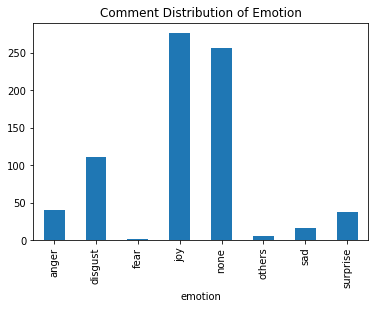

In [ ]:
dataset.groupby('emotion')['text'].count().plot(kind='bar' , title= 'Comment Distribution of Emotion')

In [ ]:
dataset['text']
dataset.head()

,id,text,emotion,lan,domain
0,23335,"kausik das, I agree with you. But government w...",none,EN,news_video
6,2598,hahahaha,joy,EN,funny_video
29,27075,Ai Song Amer Islam ka Choto kora hoisa Dislike...,disgust,EN,music_video
30,24374,"Dr. Asif Nazrul, You are Criminal and anti AL....",disgust,EN,talkshow_video
31,22062,ughhh been searching for this comment for a lo...,none,EN,funny_video


In [ ]:
def plot_model(history):
    # Plot training & validation accuracy values
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    x = range(1, len(acc) + 1)
    
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(x, acc, 'b', label='Training accuracy',linewidth=3.0)
    plt.plot(x, val_acc, 'r', label='Validation accuracy',linewidth=3.0)
    plt.title('Training and validation accuracy',fontsize=18)
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.plot(x, loss, 'b', label='Training loss',linewidth=3.0)
    plt.plot(x, val_loss, 'r', label='Validation loss',linewidth=3.0)
    plt.title('Training and validation loss', fontsize=18)
    plt.legend()


In [ ]:
from keras import backend as K

def recall_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

# 3. Label Encoding & Vectorization






In [ ]:
label_encoder = LabelEncoder()
encoded_label = label_encoder.fit_transform(emotion)

print(label_encoder.classes_)

label_OneHotEncoder = OneHotEncoder()
encoded_label = label_OneHotEncoder.fit_transform(encoded_label.reshape(-1,1)).toarray()

['anger' 'disgust' 'fear' 'joy' 'none' 'others' 'sad' 'surprise']


In [ ]:
vocabulary_size = 10000
input_length = 30

In [ ]:
tokenizer = Tokenizer(num_words= vocabulary_size)
tokenizer.fit_on_texts(dataset['text'])
sequences = tokenizer.texts_to_sequences(dataset['text'])
data = pad_sequences(sequences, maxlen = input_length)

In [ ]:
train_data, test_data, train_label, test_label = train_test_split(data, encoded_label, test_size = 0.2)

In [ ]:
num_classes = len(class_values)
validation_split = 0.2

# 4. Model Creation & Training

# LSTM Model

In [ ]:
output_dim = 8
dense_input = 1000


validation_split = 0.2
epochs = 100

callback_patience = 2

In [ ]:
callback = [EarlyStopping(monitor='val_loss', patience = callback_patience)]

In [ ]:
model_lstm = Sequential()
model_lstm.add(Embedding(vocabulary_size, dense_input, input_length = input_length))
model_lstm.add(LSTM(100, dropout=0.2, recurrent_dropout=0.2,activation='tanh'))
model_lstm.add(Dense(num_classes, activation='softmax'))
model_lstm.compile(loss='binary_crossentropy', optimizer='nadam', metrics=['accuracy',f1_m,precision_m, recall_m])

In [ ]:
model_lstm.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 30, 1000)          10000000  
_________________________________________________________________
lstm (LSTM)                  (None, 100)               440400    
_________________________________________________________________
dense (Dense)                (None, 8)                 808       
Total params: 10,441,208
Trainable params: 10,441,208
Non-trainable params: 0
_________________________________________________________________


In [ ]:
history = model_lstm.fit(train_data, train_label, validation_split = validation_split, epochs=epochs, batch_size=4,
                    shuffle = True, callbacks = callback)

Epoch 1/100
120/120 [==============================] - 24s 196ms/step - loss: 0.2866 - accuracy: 0.4151 - f1_m: 0.1486 - precision_m: 0.2764 - recall_m: 0.1083 - val_loss: 0.2807 - val_accuracy: 0.4083 - val_f1_m: 0.3202 - val_precision_m: 0.4694 - val_recall_m: 0.2667
Epoch 2/100
120/120 [==============================] - 23s 191ms/step - loss: 0.1997 - accuracy: 0.6751 - f1_m: 0.6024 - precision_m: 0.8083 - recall_m: 0.5063 - val_loss: 0.2736 - val_accuracy: 0.5167 - val_f1_m: 0.4757 - val_precision_m: 0.5944 - val_recall_m: 0.4250
Epoch 3/100
120/120 [==============================] - 23s 190ms/step - loss: 0.1096 - accuracy: 0.8239 - f1_m: 0.8205 - precision_m: 0.9215 - recall_m: 0.7625 - val_loss: 0.2964 - val_accuracy: 0.5250 - val_f1_m: 0.4310 - val_precision_m: 0.5472 - val_recall_m: 0.3750
Epoch 4/100
120/120 [==============================] - 23s 191ms/step - loss: 0.0641 - accuracy: 0.9015 - f1_m: 0.8904 - precision_m: 0.9340 - recall_m: 0.8604 - val_loss: 0.3243 - val_accur

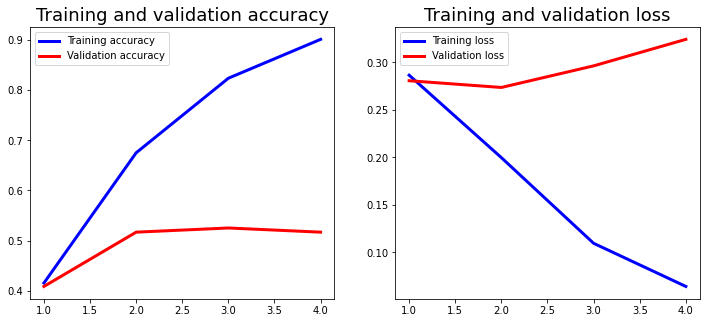

In [ ]:
plot_model(history)

In [ ]:
model_lstm.evaluate(test_data, test_label, verbose = 1)

5/5 [==============================] - 0s 13ms/step - loss: 0.3283 - accuracy: 0.5000 - f1_m: 0.4852 - precision_m: 0.5692 - recall_m: 0.4250


[0.32828766107559204,
 0.5,
 0.4851514399051666,
 0.5691994428634644,
 0.42500001192092896]

In [ ]:
model_lstm.save('/content/drive/My Drive/My Works/Bangla YouTube/model_lstm_english2.h5')

# Stacked LSTM Model

In [ ]:
output_dim = 8
dense_input = 1000

l1_dropout = 0.2
l1_recurrent_dropout = 0.2

l2_dropout = 0.2
l2_recurrent_dropout = 0.2

l1_lstm_units = 128
l2_lstm_units = 64

validation_split = 0.2
epochs = 100

callback_patience = 2

In [ ]:
callback = [EarlyStopping(monitor='val_loss', patience = callback_patience)]

In [ ]:
model = Sequential()

model.add(Embedding(vocabulary_size, dense_input, input_length = input_length))
model.add(Dense(dense_input, activation='relu'))

model.add(LSTM(l1_lstm_units, dropout = l1_dropout, recurrent_dropout = l1_recurrent_dropout, 
                             return_sequences = True, activation='relu'))
model.add(LSTM(l2_lstm_units, dropout = l2_dropout, recurrent_dropout = l2_recurrent_dropout, 
                             return_sequences = False, activation='relu'))

model.add(Dense(num_classes, activation='softmax'))

model.compile(loss='binary_crossentropy', optimizer='nadam', metrics=['accuracy',f1_m,precision_m, recall_m])

In [ ]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 30, 1000)          10000000  
_________________________________________________________________
dense_3 (Dense)              (None, 30, 1000)          1001000   
_________________________________________________________________
lstm_3 (LSTM)                (None, 30, 128)           578048    
_________________________________________________________________
lstm_4 (LSTM)                (None, 64)                49408     
_________________________________________________________________
dense_4 (Dense)              (None, 8)                 520       
Total params: 11,628,976
Trainable params: 11,628,976
Non-trainable params: 0
_________________________________________________________________


In [ ]:
history = model.fit(train_data, train_label, validation_split = validation_split, epochs=epochs, batch_size=4,
                    shuffle = True, callbacks = callback)



Epoch 1/100
120/120 [==============================] - 37s 312ms/step - loss: 1.9101 - accuracy: 0.3166 - f1_m: 0.2284 - precision_m: 0.2306 - recall_m: 0.2271 - val_loss: 2.2047 - val_accuracy: 0.4250 - val_f1_m: 0.4250 - val_precision_m: 0.4250 - val_recall_m: 0.4250
Epoch 2/100
120/120 [==============================] - 37s 305ms/step - loss: 2.5321 - accuracy: 0.3396 - f1_m: 0.3437 - precision_m: 0.3438 - recall_m: 0.3438 - val_loss: 2.2047 - val_accuracy: 0.4250 - val_f1_m: 0.4250 - val_precision_m: 0.4250 - val_recall_m: 0.4250
Epoch 3/100
120/120 [==============================] - 36s 304ms/step - loss: 2.5723 - accuracy: 0.3291 - f1_m: 0.3333 - precision_m: 0.3333 - recall_m: 0.3333 - val_loss: 2.2047 - val_accuracy: 0.4250 - val_f1_m: 0.4250 - val_precision_m: 0.4250 - val_recall_m: 0.4250


In [ ]:
model.evaluate(test_data, test_label, verbose = 1)

5/5 [==============================] - 0s 19ms/step - loss: 2.4795 - accuracy: 0.3533 - f1_m: 0.3597 - precision_m: 0.3597 - recall_m: 0.3597


[2.479496955871582,
 0.35333332419395447,
 0.35965901613235474,
 0.3596591055393219,
 0.3596591055393219]

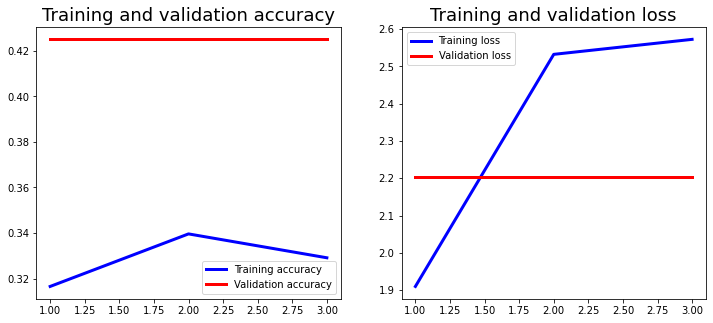

In [ ]:
plot_model(history)

In [ ]:
model.save('/content/drive/My Drive/My Works/Bangla YouTube/model_stacked_lstm_english2.h5')

# Stacked LSTM with CNN using pre-trained word embeddings

In [ ]:
glove_dir =  '/content/drive/My Drive/My Works/Spam Filtering/glove.6B.100d.txt'

In [ ]:
output_dim=100

In [ ]:
embeddings_index = dict()
f = open(glove_dir, encoding="utf8")
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()

In [ ]:
embedding_matrix = np.zeros((vocabulary_size, output_dim))
for word, index in tokenizer.word_index.items():
    if index > vocabulary_size - 1:
        break
    else:
        embedding_vector = embeddings_index.get(word)
        if embedding_vector is not None:
            embedding_matrix[index] = embedding_vector

In [ ]:
output_dim = 100
dense_input = 1000

dropout = 0.3

conv1D_filters = 100
conv1D_kernel_size = 4

pool_size = 5

l1_dropout = 0.2
l1_recurrent_dropout = 0.2

l2_dropout = 0.2
l2_recurrent_dropout = 0.2

l1_lstm_units = 64
l2_lstm_units = 32

In [ ]:
model_glove = Sequential()
model_glove.add(Embedding(vocabulary_size, output_dim, input_length = input_length, 
                          weights=[embedding_matrix], trainable=False))
model_glove.add(Dropout(dropout))

model_glove.add(Dense(output_dim, activation='relu'))

model_glove.add(Conv1D(filters = conv1D_filters, kernel_size = conv1D_kernel_size, 
                       activation='relu'))
model_glove.add(MaxPooling1D(pool_size = pool_size))

model_glove.add(LSTM(l1_lstm_units , dropout = l1_dropout,
                     return_sequences=True, activation='relu'))
model_glove.add(LSTM(l2_lstm_units , dropout = l2_dropout,
                     return_sequences=False , activation='relu'))

model_glove.add(Dense(8, activation='softmax'))

model_glove.compile(loss='binary_crossentropy', optimizer='nadam', metrics=['accuracy',f1_m,precision_m, recall_m])

In [ ]:
model_glove.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, 30, 100)           1000000   
_________________________________________________________________
dropout (Dropout)            (None, 30, 100)           0         
_________________________________________________________________
dense_5 (Dense)              (None, 30, 100)           10100     
_________________________________________________________________
conv1d (Conv1D)              (None, 27, 100)           40100     
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 5, 100)            0         
_________________________________________________________________
lstm_5 (LSTM)                (None, 5, 64)             42240     
_________________________________________________________________
lstm_6 (LSTM)                (None, 32)               

Epoch 1/100
120/120 [==============================] - 4s 30ms/step - loss: 0.3137 - accuracy: 0.3732 - f1_m: 0.0270 - precision_m: 0.0306 - recall_m: 0.0250 - val_loss: 0.2857 - val_accuracy: 0.4667 - val_f1_m: 0.0000e+00 - val_precision_m: 0.0000e+00 - val_recall_m: 0.0000e+00
Epoch 2/100
120/120 [==============================] - 3s 27ms/step - loss: 0.2827 - accuracy: 0.3899 - f1_m: 0.0568 - precision_m: 0.1111 - recall_m: 0.0396 - val_loss: 0.2952 - val_accuracy: 0.3333 - val_f1_m: 0.0800 - val_precision_m: 0.2000 - val_recall_m: 0.0500
Epoch 3/100
120/120 [==============================] - 3s 26ms/step - loss: 0.2799 - accuracy: 0.4025 - f1_m: 0.0575 - precision_m: 0.1181 - recall_m: 0.0396 - val_loss: 0.2910 - val_accuracy: 0.4083 - val_f1_m: 0.0133 - val_precision_m: 0.0333 - val_recall_m: 0.0083


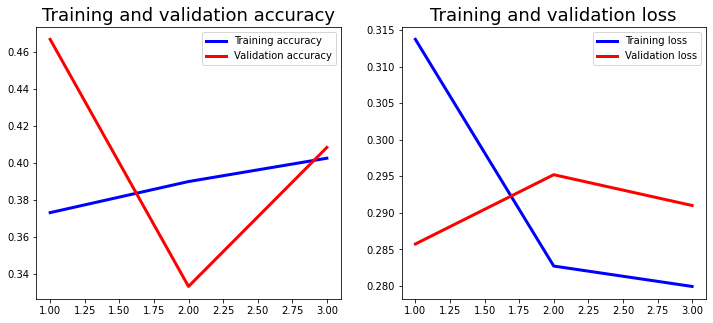

In [ ]:
history = model_glove.fit(train_data, train_label, validation_split = validation_split, epochs = epochs, batch_size=4, 
                          shuffle = True, callbacks = callback)

plot_model(history)

In [ ]:
model_glove.save('/content/drive/My Drive/My Works/Bangla YouTube/model_stacked_lstm_pretrained_english2.h5')

In [ ]:
model_glove.evaluate(test_data, test_label, verbose = 1)

5/5 [==============================] - 0s 7ms/step - loss: 0.2916 - accuracy: 0.4333 - f1_m: 0.0121 - precision_m: 0.2000 - recall_m: 0.0063


[0.2915779948234558,
 0.4333333373069763,
 0.012121210806071758,
 0.19999997317790985,
 0.0062500000931322575]

In [ ]:
model_conv.predict(test_data[0:1])

array([[0.05119932, 0.14143829, 0.00459995, 0.3556276 , 0.3531869 ,
        0.00714228, 0.03095772, 0.05584806]], dtype=float32)

# 5. Testing the all the above models with a random text

In [ ]:
test_text = 'wow'
test_text = pd.Series(test_text)

sequences = tokenizer.texts_to_sequences(test_text)
data = pad_sequences(sequences, maxlen = input_length)

In [ ]:
label_encoder.classes_[np.argmax(model.predict(data))]

'joy'

In [ ]:
label_encoder.classes_[np.argmax(model_lstm.predict(data))]

'joy'

In [ ]:
label_encoder.classes_[np.argmax(model_glove.predict(data))]

'none'

In [ ]:
print(label_encoder.classes_)

['anger' 'disgust' 'fear' 'joy' 'none' 'others' 'sad' 'surprise']


In [ ]:
np.around(model.predict(data), decimals = 2)

array([[0.01, 0.01, 0.  , 0.91, 0.03, 0.  , 0.01, 0.03]], dtype=float32)

In [ ]:
np.around(model_conv.predict(data), decimals = 2)

array([[0.05, 0.14, 0.  , 0.36, 0.35, 0.01, 0.03, 0.06]], dtype=float32)

In [ ]:
np.around(model_glove.predict(data), decimals = 2)

array([[0.02, 0.07, 0.  , 0.3 , 0.53, 0.01, 0.01, 0.04]], dtype=float32)

In [ ]:
np.around(model_lstm.predict(data), decimals = 2)

array([[0., 0., 0., 1., 0., 0., 0., 0.]], dtype=float32)